# Decision-Focused Learning 

### Library import

In [82]:
import os, random, numpy as np, pandas as pd, torch, cvxpy as cp, matplotlib.pyplot as plt
from tqdm import tqdm
import sys, subprocess
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.covariance import LedoitWolf


SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
def _pip_install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

try:
    import yfinance
except ImportError:
    _pip_install("yfinance")

### Load and prepare financial data  
Download stock price data from Yahoo Finance and compute returns, mean vector (μ), and covariance matrix (Σ).

In [29]:
from sklearn.covariance import LedoitWolf
def get_portfolio_data(tickers, start="2018-01-01", end="2023-12-31", freq="1d", visualize=True):
    print(f"Downloading {len(tickers)} assets from {start} to {end} ...")
    data = yf.download(
        tickers,
        start=start,
        end=end,
        interval=freq,
        group_by="column",
        auto_adjust=True,
        progress=False,
        threads=True,
    )

    if data.empty:
        raise RuntimeError("Downloaded data is empty. Check tickers, dates or internet connection.")

    if isinstance(data.columns, pd.MultiIndex):
        lvl0 = data.columns.get_level_values(0)
        if "Close" in lvl0:
            prices = data.xs("Close", axis=1, level=0)
        elif "Adj Close" in lvl0:
            prices = data.xs("Adj Close", axis=1, level=0)
        else:
            raise KeyError(f"Expected 'Close' or 'Adj Close' in columns level-0. Found: {sorted(set(lvl0))}")
    else:
        cols = data.columns
        if "Close" in cols:
            prices = data["Close"].to_frame() if not isinstance(tickers, (list, tuple)) else data["Close"]
        elif "Adj Close" in cols:
            prices = data["Adj Close"].to_frame() if not isinstance(tickers, (list, tuple)) else data["Adj Close"]
        else:
            raise KeyError(f"Expected 'Close' or 'Adj Close' in columns. Found: {list(cols)}")

    prices = prices.dropna(axis=0, how="any")
    if prices.empty:
        raise RuntimeError("Prices are empty after dropna(). Try a wider date range or different tickers.")

    returns = np.log(prices / prices.shift(1)).dropna()
    mu = returns.mean().values
    Sigma = returns.cov().values

    if visualize:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        prices.plot(ax=axes[0], legend=False)
        axes[0].set_title("Adjusted Close (auto_adjust=True)"); axes[0].set_xlabel("Date"); axes[0].set_ylabel("Price")
        corr = returns.corr()
        im = axes[1].imshow(corr, vmin=-1, vmax=1)
        axes[1].set_xticks(range(len(corr.columns))); axes[1].set_xticklabels(corr.columns, rotation=45, ha="right")
        axes[1].set_yticks(range(len(corr.index)));  axes[1].set_yticklabels(corr.index)
        axes[1].set_title("Return Correlation Heatmap")
        fig.colorbar(im, ax=axes[1])
        plt.tight_layout(); plt.show()

    return prices, returns, mu, Sigma

# Data Cleaning and Stabilization Block 

In [30]:
def clean_and_stabilize_data(returns, window=5, winsorize_limit=0.02, visualize=True):
    clipped = returns.clip(lower=returns.quantile(winsorize_limit),
                           upper=returns.quantile(1 - winsorize_limit), axis=1)
    smoothed = clipped.rolling(window=window, min_periods=1).mean()
    mu_clean = smoothed.mean().values
    lw = LedoitWolf().fit(smoothed.dropna())
    Sigma_clean = lw.covariance_

    if visualize:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        smoothed.plot(ax=axes[0], legend=False)
        axes[0].set_title("Smoothed Returns (rolling mean)")
        corr = pd.DataFrame(Sigma_clean, index=returns.columns, columns=returns.columns).corr()
        im = axes[1].imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
        axes[1].set_title("Covariance (Ledoit–Wolf shrinked)")
        plt.colorbar(im, ax=axes[1])
        plt.tight_layout()
        plt.show()

    return smoothed, mu_clean, Sigma_clean

### Run data fetching  
Select a list of assets and retrieve prices, returns, and covariance matrix.

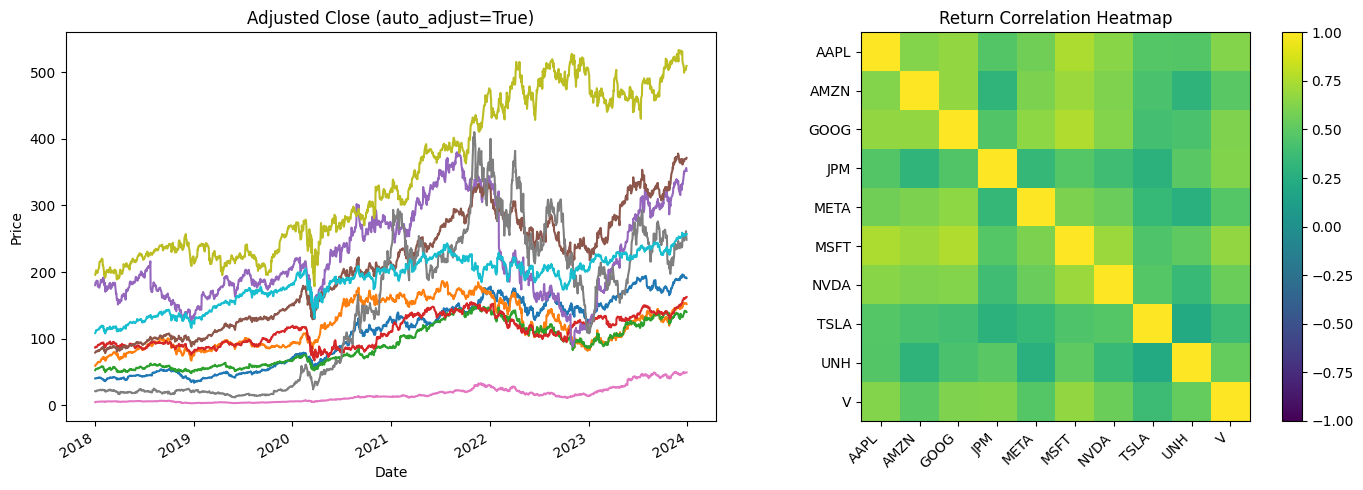


Raw data:
μ (mean returns) first 5: [0.00103 0.00062 0.00065 0.00042 0.00044]
Σ shape: (10, 10)


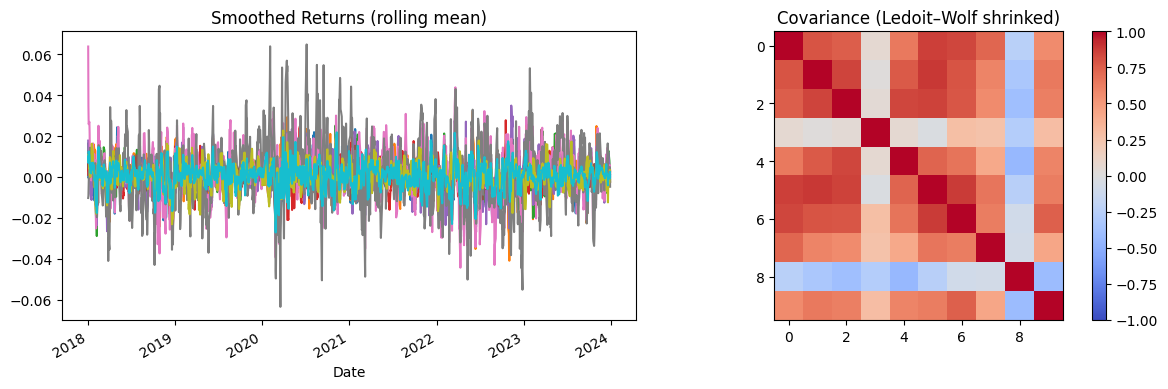


After cleaning:
μ (mean returns) first 5: [0.00099 0.00056 0.00061 0.0004  0.00068]
Σ shape: (10, 10)


In [31]:
# 1️⃣ Scarico i dati grezzi
tickers = ["AAPL", "MSFT", "AMZN", "GOOG", "META", "NVDA", "JPM", "TSLA", "UNH", "V"]

prices, returns, mu, Sigma = get_portfolio_data(
    tickers=tickers,
    start="2018-01-01",
    end="2023-12-31",
    freq="1d",
    visualize=True
)

print("\nRaw data:")
print("μ (mean returns) first 5:", np.round(mu[:5], 5))
print("Σ shape:", Sigma.shape)

# 2️⃣ Pulisco e stabilizzo i rendimenti
returns_clean, mu, Sigma = clean_and_stabilize_data(returns, window=5, winsorize_limit=0.02, visualize=True)

print("\nAfter cleaning:")
print("μ (mean returns) first 5:", np.round(mu[:5], 5))
print("Σ shape:", Sigma.shape)

### Build supervised dataset (lags) and temporal split  
Transform the return matrix into a supervised learning dataset:  
features = last L days of returns for each asset;  
target = next-day return vector for all assets.  
We perform a chronological split: train (2018–2021), validation (2022), test (2023).

In [32]:
def build_supervised_from_returns(R: pd.DataFrame, lags: int = 5):
    R = R.copy()
    X_list, Y_list, dates = [], [], []

    for t in range(lags, len(R) - 1):
        X_t = R.iloc[t - lags:t].values.flatten()
        Y_t = R.iloc[t + 1].values
        X_list.append(X_t)
        Y_list.append(Y_t)
        dates.append(R.index[t + 1])

    X = np.array(X_list)
    Y = np.array(Y_list)
    dates = pd.to_datetime(dates)
    feature_names = [f"{col}_lag{l}" for l in range(lags, 0, -1) for col in R.columns]
    return X, Y, dates, feature_names


LAGS = 5
X_all, Y_all, dates_all, feat_names = build_supervised_from_returns(returns_clean, lags=LAGS)

print("Supervised dataset shapes:")
print("  X_all:", X_all.shape)
print("  Y_all:", Y_all.shape)
print("  Date range:", dates_all.min(), "→", dates_all.max())

split_train, split_val, split_test = "2022-01-01", "2023-01-01", "2023-12-01"

train_mask = dates_all < split_train
val_mask   = (dates_all >= split_train) & (dates_all < split_val)
test_mask  = dates_all >= split_val

print("\nDate coverage:")
print("Train:", dates_all[train_mask].min(), "→", dates_all[train_mask].max())
print("Val:  ", dates_all[val_mask].min(), "→", dates_all[val_mask].max())
print("Test: ", dates_all[test_mask].min(), "→", dates_all[test_mask].max())

X_train, Y_train = X_all[train_mask], Y_all[train_mask]
X_val,   Y_val   = X_all[val_mask],   Y_all[val_mask]
X_test,  Y_test  = X_all[test_mask],  Y_all[test_mask]

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("\nShapes:")
print("  X_train, Y_train:", X_train_s.shape, Y_train.shape)
print("  X_val,   Y_val:  ", X_val_s.shape,   Y_val.shape)
print("  X_test,  Y_test: ", X_test_s.shape,  Y_test.shape)
print("Assets (N):", Y_train.shape[1], " | Lags:", LAGS, " | Features:", X_train_s.shape[1])

Supervised dataset shapes:
  X_all: (1502, 50)
  Y_all: (1502, 10)
  Date range: 2018-01-11 00:00:00 → 2023-12-29 00:00:00

Date coverage:
Train: 2018-01-11 00:00:00 → 2021-12-31 00:00:00
Val:   2022-01-03 00:00:00 → 2022-12-30 00:00:00
Test:  2023-01-03 00:00:00 → 2023-12-29 00:00:00

Shapes:
  X_train, Y_train: (1001, 50) (1001, 10)
  X_val,   Y_val:   (251, 50) (251, 10)
  X_test,  Y_test:  (250, 50) (250, 10)
Assets (N): 10  | Lags: 5  | Features: 50


# PtO

### Train multi-output predictor (μ̂) on lags
We fit a ridge multi-output model on standardized lag features to predict next-day returns for all assets.

In [34]:
alphas = np.logspace(-4, 4, 21)
ridge = RidgeCV(alphas=alphas, fit_intercept=True, cv=None)
ridge.fit(X_train_s, Y_train)

Y_val_pred = ridge.predict(X_val_s)
Y_test_pred = ridge.predict(X_test_s)

print("Ridge fitted. Val/Test shapes:", Y_val_pred.shape, Y_test_pred.shape)

Ridge fitted. Val/Test shapes: (251, 10) (250, 10)


### Quadratic program for portfolio choice 
Minimize  (1/2) xᵀ Σ x − (1/λ) μᵀ x  subject to  1ᵀx=1, x≥0.
We ensure Σ is PSD by adding εI if needed.

In [35]:
def project_psd(S, eps=1e-8):
    w, V = np.linalg.eigh((S + S.T) / 2)
    w_clipped = np.clip(w, eps, None)
    return V @ np.diag(w_clipped) @ V.T

def solve_markowitz(mu_vec, Sigma_mat, lam=10.0, long_only=True):
    N = len(mu_vec)
    x = cp.Variable(N)
    Sigma_psd = project_psd(Sigma_mat)
    objective = 0.5 * cp.quad_form(x, Sigma_psd) - (1.0 / lam) * mu_vec @ x
    constraints = [cp.sum(x) == 1]
    if long_only:
        constraints.append(x >= 0)
    problem = cp.Problem(cp.Minimize(objective), constraints)
    problem.solve(solver=cp.OSQP, eps_abs=1e-8, eps_rel=1e-8, verbose=False)
    return np.array(x.value).ravel()

### Validation: select λ by minimizing average validation regret
For each date τ in validation, compute x(μ̂_τ; λ) and the *decision loss* under true μ_τ:
L(μ̂_τ, μ_τ; λ) = f(x(μ̂_τ), μ_τ) − f(x*(μ_τ), μ_τ), where f(x, μ)=½ xᵀΣx − (1/λ) μᵀx.
We average regret across τ and pick λ* with minimal regret.

In [36]:
dates_train = dates_all[dates_all < "2022-01-01"]
Sigma_train = returns_clean.loc[returns_clean.index.isin(dates_train)].cov().values

def decision_objective(x, mu_vec, Sigma_mat, lam):
    return 0.5 * x @ Sigma_mat @ x - (1.0 / lam) * (mu_vec @ x)

def average_regret(mu_pred_seq, mu_true_seq, Sigma_mat, lam):
    regrets = []
    for mu_hat, mu_true in zip(mu_pred_seq, mu_true_seq):
        x_hat = solve_markowitz(mu_hat, Sigma_mat, lam)
        x_star = solve_markowitz(mu_true, Sigma_mat, lam)
        loss_hat = decision_objective(x_hat, mu_true, Sigma_mat, lam)
        loss_star = decision_objective(x_star, mu_true, Sigma_mat, lam)
        regrets.append(loss_hat - loss_star)
    return float(np.mean(regrets)), np.array(regrets)

lambda_grid = np.logspace(-2, 2, 15)
val_regrets = []
for lam in lambda_grid:
    avg_reg, _ = average_regret(Y_val_pred, Y_val, Sigma_train, lam)
    val_regrets.append(avg_reg)

lam_star = float(lambda_grid[np.argmin(val_regrets)])
print("Chosen λ* (min avg regret on validation):", lam_star)

Chosen λ* (min avg regret on validation): 100.0


### Test evaluation: regret, realized cumulative return, Sharpe
We evaluate decision quality on test dates using λ*.  
We also compute realized daily returns of the chosen portfolio: r_t = x_t(μ̂_t)ᵀ · μ_true_t, and summarize with cumulative return and Sharpe.

In [38]:
### Test Evaluation: Decision Regret, Realized Return, Sharpe Ratio

avg_reg_test, regrets_test = average_regret(Y_test_pred, Y_test, Sigma_train, lam_star)

def realized_path(mu_pred_seq, mu_true_seq, Sigma_mat, lam):
    rets = []
    weights = []
    for mu_hat, mu_true in zip(mu_pred_seq, mu_true_seq):
        x_hat = solve_markowitz(mu_hat, Sigma_mat, lam)
        weights.append(x_hat)
        rets.append(float(x_hat @ mu_true))
    return np.array(rets), np.array(weights)

test_realized, test_weights = realized_path(Y_test_pred, Y_test, Sigma_train, lam_star)
cum_ret = np.cumprod(1.0 + test_realized) - 1.0
sharpe = np.mean(test_realized) / (np.std(test_realized) + 1e-12) * np.sqrt(252)

print("Test avg regret:", np.round(avg_reg_test, 6))
print("Test realized mean daily return:", np.round(test_realized.mean(), 6))
print("Test Sharpe (annualized):", np.round(sharpe, 3))
print("Final cumulative return:", np.round(cum_ret[-1], 3))

Test avg regret: 3.3e-05
Test realized mean daily return: 0.007518
Test Sharpe (annualized): 17.082
Final cumulative return: 5.466



### Baselines for context: clairvoyant and equal-weight

In [39]:

def clairvoyant_realized(mu_true_seq, Sigma_mat, lam):
    rets = []
    for mu_true in mu_true_seq:
        x_star = solve_markowitz(mu_true, Sigma_mat, lam)
        rets.append(float(x_star @ mu_true))
    rets = np.array(rets)
    cum = np.cumprod(1.0 + rets) - 1.0
    return rets, cum

def equal_weight_realized(mu_true_seq):
    N = mu_true_seq.shape[1]
    x_eq = np.ones(N) / N
    rets = mu_true_seq @ x_eq
    cum = np.cumprod(1.0 + rets) - 1.0
    return rets, cum

# Usa la matrice di covarianza "pulita"
cw_rets, cw_cum = clairvoyant_realized(Y_test, Sigma_train, lam_star)
eq_rets, eq_cum = equal_weight_realized(Y_test)

cw_sharpe = cw_rets.mean() / (cw_rets.std() + 1e-12) * np.sqrt(252)
eq_sharpe = eq_rets.mean() / (eq_rets.std() + 1e-12) * np.sqrt(252)

print("Clairvoyant Sharpe (annualized):", np.round(cw_sharpe, 3), "| Final cum:", np.round(cw_cum[-1], 3))
print("Equal-weight Sharpe (annualized):", np.round(eq_sharpe, 3), "| Final cum:", np.round(eq_cum[-1], 3))

Clairvoyant Sharpe (annualized): 22.765 | Final cum: 16.432
Equal-weight Sharpe (annualized): 6.25 | Final cum: 0.652


### Cumulative returns and regret distribution
Cumulative performance vs baselines and the distribution of test regrets.

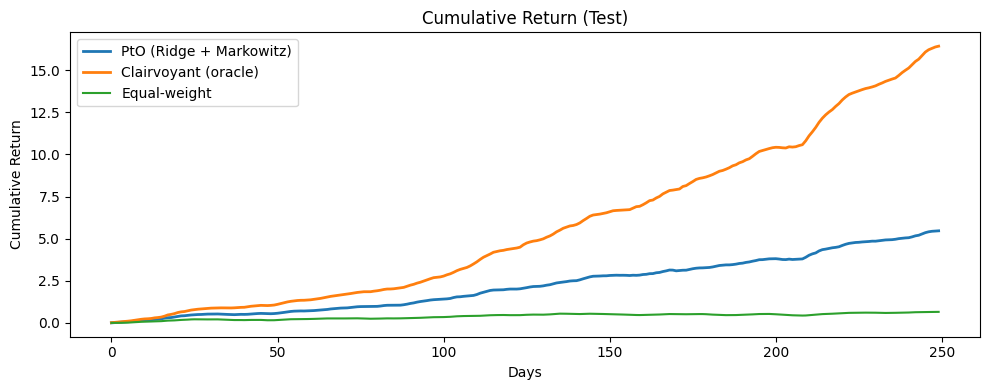

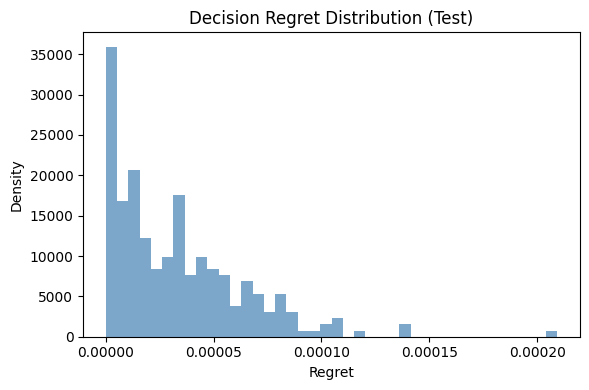

In [40]:
plt.figure(figsize=(10,4))
plt.plot(cum_ret, label="PtO (Ridge + Markowitz)", color="tab:blue", linewidth=2)
plt.plot(cw_cum, label="Clairvoyant (oracle)", color="tab:orange", linewidth=2)
plt.plot(eq_cum, label="Equal-weight", color="tab:green", linewidth=1.5)
plt.title("Cumulative Return (Test)")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(regrets_test, bins=40, density=True, color="steelblue", alpha=0.7)
plt.title("Decision Regret Distribution (Test)")
plt.xlabel("Regret")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

### Robustness: decision quality under prediction noise




In [41]:
mu_test_pred = Y_test_pred
R_test = Y_test
risk_aversion = lam_star
Sigma_used = Sigma_train  # matrice stabile e coerente con la fase di training

print("mu_test_pred shape:", mu_test_pred.shape)
print("R_test shape:", R_test.shape)
print("risk_aversion:", risk_aversion)

def evaluate_sequence(mu_seq, R_seq, Sigma, risk_aversion):
    T, N = mu_seq.shape
    w_seq = np.zeros((T, N))
    for t in range(T):
        w_seq[t] = solve_markowitz(mu_seq[t], Sigma, risk_aversion, long_only=True)
    port_rets = np.sum(w_seq * R_seq, axis=1)
    cum = np.cumprod(1.0 + port_rets) - 1.0
    sharpe = np.sqrt(252.0) * np.mean(port_rets) / (np.std(port_rets) + 1e-12)
    return {
        "w_seq": w_seq,
        "port_rets": port_rets,
        "cum_final": float(cum[-1]),
        "sharpe": float(sharpe),
        "avg_ret": float(np.mean(port_rets))
    }

def compute_avg_regret(mu_seq, R_seq, Sigma, risk_aversion):
    T, N = mu_seq.shape
    regret = []
    for t in range(T):
        w_hat = solve_markowitz(mu_seq[t], Sigma, risk_aversion, long_only=True)
        w_star = solve_markowitz(R_seq[t], Sigma, risk_aversion, long_only=True)
        u_hat = float(R_seq[t] @ w_hat - 0.5 * risk_aversion * w_hat @ Sigma @ w_hat)
        u_star = float(R_seq[t] @ w_star - 0.5 * risk_aversion * w_star @ Sigma @ w_star)
        regret.append(u_star - u_hat)
    return float(np.mean(regret))

import time

sig_base = float(np.std(mu_test_pred))
noise_levels = [0.0, 0.05*sig_base, 0.1*sig_base, 0.25*sig_base, 0.5*sig_base, 1.0*sig_base]

rows = []
for sig in noise_levels:
    rng = np.random.default_rng(42)
    mu_noisy = mu_test_pred + sig * rng.standard_normal(mu_test_pred.shape)
    t0 = time.time()
    metrics = evaluate_sequence(mu_noisy, R_test, Sigma_used, risk_aversion)
    avg_reg = compute_avg_regret(mu_noisy, R_test, Sigma_used, risk_aversion)
    dt = time.time() - t0
    rows.append({
        "noise_sigma": sig,
        "test_avg_regret": avg_reg,
        "test_sharpe": metrics["sharpe"],
        "final_cum_return": metrics["cum_final"],
        "eval_time_sec": dt
    })

robust_df = pd.DataFrame(rows)
display(robust_df)

mu_test_pred shape: (250, 10)
R_test shape: (250, 10)
risk_aversion: 100.0


,noise_sigma,test_avg_regret,test_sharpe,final_cum_return,eval_time_sec
0,0.000000,0.003327,17.082053,5.466060,6.150205
1,0.000264,0.003323,17.116791,5.470574,3.435766
2,0.000528,0.003352,17.118458,5.422559,3.357540
3,0.001320,0.003568,16.783011,5.103978,3.330957
4,0.002639,0.004159,15.660962,4.311324,3.324230
5,0.005278,0.005300,13.095005,2.977491,3.411950


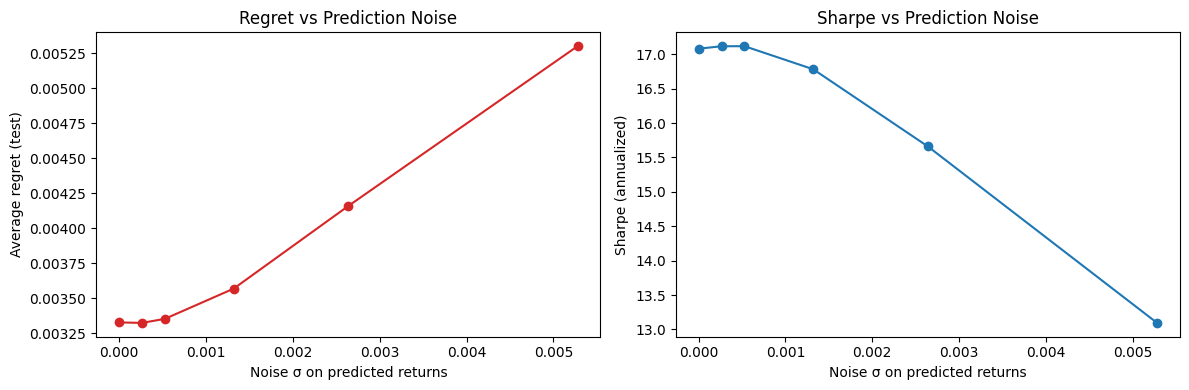

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(robust_df["noise_sigma"], robust_df["test_avg_regret"], marker="o", color="tab:red")
ax[0].set_xlabel("Noise σ on predicted returns")
ax[0].set_ylabel("Average regret (test)")
ax[0].set_title("Regret vs Prediction Noise")

ax[1].plot(robust_df["noise_sigma"], robust_df["test_sharpe"], marker="o", color="tab:blue")
ax[1].set_xlabel("Noise σ on predicted returns")
ax[1].set_ylabel("Sharpe (annualized)")
ax[1].set_title("Sharpe vs Prediction Noise")

plt.tight_layout()
plt.show()

### Computational Efficiency and Solver Integration

Avg solve time (N=10): 4.83 ms ± 0.76 ms


,N_assets,avg_time_sec
0,5,0.004366
1,10,0.004857
2,20,0.004942
3,30,0.005583
4,40,0.004991


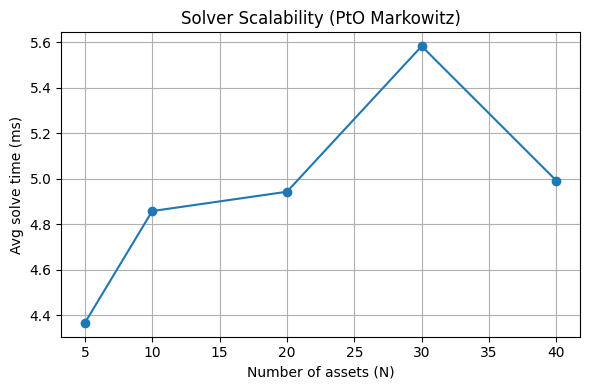

In [45]:
def benchmark_solver(mu_seq, Sigma, lam, solver="OSQP"):
    times = []
    for mu in mu_seq:
        start = time.time()
        _ = solve_markowitz(mu, Sigma, lam, long_only=True)
        times.append(time.time() - start)
    return np.mean(times), np.std(times)

mean_t, std_t = benchmark_solver(Y_test_pred[:50], Sigma_train, lam_star)
print(f"Avg solve time (N=10): {mean_t*1000:.2f} ms ± {std_t*1000:.2f} ms")

scalability = []
for n_assets in [5, 10, 20, 30, 40]:
    idx = np.arange(min(n_assets, Y_test_pred.shape[1]))
    Sigma_sub = Sigma_train[np.ix_(idx, idx)]
    mu_sub_seq = [mu[idx] for mu in Y_test_pred[:20]]
    mean_t, _ = benchmark_solver(mu_sub_seq, Sigma_sub, lam_star)
    scalability.append((n_assets, mean_t))

scal_df = pd.DataFrame(scalability, columns=["N_assets", "avg_time_sec"])
display(scal_df)

plt.figure(figsize=(6,4))
plt.plot(scal_df["N_assets"], scal_df["avg_time_sec"]*1000, marker="o")
plt.title("Solver Scalability (PtO Markowitz)")
plt.xlabel("Number of assets (N)")
plt.ylabel("Avg solve time (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()

# SPO+

## SPO⁺ Benchmark: Convex Surrogate Decision Loss
### training and evaluation
In this stage, we evaluate the SPO⁺ loss proposed by *Elmachtoub & Grigas (2017, 2022)*, 
which measures the decision-aware performance of predictive models. 
Unlike standard MSE, SPO⁺ explicitly captures how prediction errors translate into suboptimal decisions 
in the downstream optimization layer.

The model is trained using MSE for stability, and evaluated with SPO⁺ as a validation metric.
This provides a quantitative link between predictive accuracy and decision quality.


In [46]:
def solve_markowitz(mu_vec, Sigma_mat, lam=10.0):
    N = len(mu_vec)
    x = cp.Variable(N)
    Sigma_psd = project_psd(Sigma_mat)  # ensure PSD
    obj = 0.5 * cp.quad_form(x, Sigma_psd) - (1.0 / lam) * mu_vec @ x
    cons = [cp.sum(x) == 1, x >= 0]
    prob = cp.Problem(cp.Minimize(obj), cons)
    prob.solve(solver=cp.OSQP, verbose=False)
    return np.array(x.value).ravel()

def spo_plus_loss(mu_pred, mu_true, Sigma, lam):
    total = 0.0
    count = 0
    for i in range(mu_pred.shape[0]):
        mu_hat = mu_pred[i].detach().cpu().numpy()
        mu_ref = mu_true[i].detach().cpu().numpy()
        x_true = solve_markowitz(mu_ref, Sigma, lam)
        x_loss = solve_markowitz(2 * mu_hat - mu_ref, Sigma, lam)
        total += float(mu_ref @ (x_loss - x_true))
        count += 1
    return total / count

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_s, dtype=torch.float32).to(device)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).to(device)
X_val_t   = torch.tensor(X_val_s, dtype=torch.float32).to(device)
Y_val_t   = torch.tensor(Y_val, dtype=torch.float32).to(device)

class SmallNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(SmallNet, self).__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, out_dim)
    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

model = SmallNet(X_train_t.shape[1], Y_train_t.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

Sigma_t = Sigma_train.copy()
lam_spo = lam_star
epochs = 10

for ep in range(epochs):
    model.train()
    optimizer.zero_grad()
    mu_pred = model(X_train_t)
    loss_mse = mse_loss(mu_pred, Y_train_t)
    loss_mse.backward()
    optimizer.step()

    with torch.no_grad():
        model.eval()
        mu_val = model(X_val_t)
        val_loss = mse_loss(mu_val, Y_val_t)
        spo_val = spo_plus_loss(mu_val, Y_val_t, Sigma_t, lam_spo)

    print(f"Epoch {ep+1}/{epochs}  |  Train MSE: {loss_mse.item():.6f}  |  Val MSE: {val_loss.item():.6f}  |  Val SPO⁺: {spo_val:.6f}")

Epoch 1/10  |  Train MSE: 0.071717  |  Val MSE: 0.114567  |  Val SPO⁺: -0.011473
Epoch 2/10  |  Train MSE: 0.060496  |  Val MSE: 0.093307  |  Val SPO⁺: -0.011520
Epoch 3/10  |  Train MSE: 0.051001  |  Val MSE: 0.075873  |  Val SPO⁺: -0.011936
Epoch 4/10  |  Train MSE: 0.043067  |  Val MSE: 0.061868  |  Val SPO⁺: -0.012098
Epoch 5/10  |  Train MSE: 0.036525  |  Val MSE: 0.050779  |  Val SPO⁺: -0.012325
Epoch 6/10  |  Train MSE: 0.031202  |  Val MSE: 0.042172  |  Val SPO⁺: -0.012063
Epoch 7/10  |  Train MSE: 0.026925  |  Val MSE: 0.035600  |  Val SPO⁺: -0.012188
Epoch 8/10  |  Train MSE: 0.023527  |  Val MSE: 0.030725  |  Val SPO⁺: -0.012105
Epoch 9/10  |  Train MSE: 0.020851  |  Val MSE: 0.027209  |  Val SPO⁺: -0.011945
Epoch 10/10  |  Train MSE: 0.018758  |  Val MSE: 0.024740  |  Val SPO⁺: -0.011557


### SPO⁺ Test Evaluation

We evaluate the SPO⁺ model on the test period, computing:
- **Average decision regret**, as the mean excess loss relative to the oracle decision,
- **Realized portfolio return**, using the predicted mean returns,
- **Annualized Sharpe ratio** and **final cumulative return**.

This mirrors the evaluation used for PtO and DFL, enabling a consistent comparison 
between decision-focused and prediction-focused frameworks.

In [49]:
Y_test_pred_spo = model(torch.tensor(X_test_s, dtype=torch.float32, device=device)).detach().cpu().numpy()
Sigma_test = Sigma_train.copy()

def decision_eval(mu_pred_seq, mu_true_seq, Sigma_mat, lam):
    regrets, rets = [], []
    for mu_hat, mu_true in zip(mu_pred_seq, mu_true_seq):
        x_hat  = solve_markowitz(mu_hat, Sigma_mat, lam)
        x_star = solve_markowitz(mu_true, Sigma_mat, lam)
        f_hat  = 0.5 * x_hat @ Sigma_mat @ x_hat - (1.0 / lam) * (mu_true @ x_hat)
        f_star = 0.5 * x_star @ Sigma_mat @ x_star - (1.0 / lam) * (mu_true @ x_star)
        regrets.append(f_hat - f_star)
        rets.append(mu_true @ x_hat)
    return float(np.mean(regrets)), np.array(rets)

avg_reg_spo, rets_spo = decision_eval(Y_test_pred_spo, Y_test, Sigma_test, lam_star)
cum_ret_spo = np.cumprod(1.0 + rets_spo) - 1.0
sharpe_spo = np.sqrt(252.0) * rets_spo.mean() / (rets_spo.std() + 1e-12)

print("\nSPO⁺ test results")
print("  Avg regret:", round(avg_reg_spo, 6))
print("  Annualized Sharpe:", round(sharpe_spo, 3))
print("  Final cumulative return:", round(float(cum_ret_spo[-1]), 3))


SPO⁺ test results
  Avg regret: 9.6e-05
  Annualized Sharpe: 5.001
  Final cumulative return: 1.004


### Comparison Plot: SPO⁺ vs PtO vs Equal-Weight

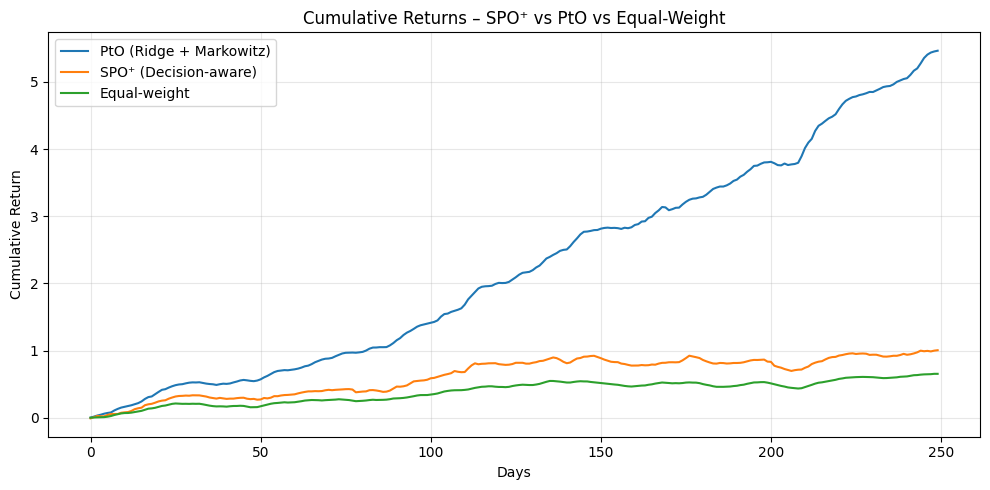


Summary comparison:
  PtO Sharpe: 17.082  |  SPO⁺ Sharpe: 5.001  |  Equal-Weight Sharpe: 6.25
  PtO Final cum: 5.466  |  SPO⁺ Final cum: 1.004  |  Equal-Weight Final cum: 0.652


In [50]:
# Reuse existing PtO and equal-weight results
# (cw_cum, eq_cum, cum_ret come from previous PtO evaluation)

plt.figure(figsize=(10,5))
plt.plot(cum_ret, label="PtO (Ridge + Markowitz)", color="tab:blue")
plt.plot(cum_ret_spo, label="SPO⁺ (Decision-aware)", color="tab:orange")
plt.plot(eq_cum, label="Equal-weight", color="tab:green")
plt.title("Cumulative Returns – SPO⁺ vs PtO vs Equal-Weight")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nSummary comparison:")
print(f"  PtO Sharpe: {np.round(sharpe, 3)}  |  SPO⁺ Sharpe: {np.round(sharpe_spo, 3)}  |  Equal-Weight Sharpe: {np.round(eq_sharpe, 3)}")
print(f"  PtO Final cum: {np.round(cum_ret[-1], 3)}  |  SPO⁺ Final cum: {np.round(cum_ret_spo[-1], 3)}  |  Equal-Weight Final cum: {np.round(eq_cum[-1], 3)}")

# DFL with Differential opt

### 1 — Differentiable Decision Layer


In [51]:
import torch
import cvxpy as cp
import numpy as np
from cvxpylayers.torch import CvxpyLayer

def make_psd(Sigma):
    """Ensure the covariance matrix is symmetric positive semidefinite."""
    Sigma = (Sigma + Sigma.T) / 2
    eigvals, eigvecs = np.linalg.eigh(Sigma)
    eigvals[eigvals < 1e-8] = 1e-8
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

Sigma_psd_np = make_psd(Sigma_train)
N = Sigma_psd_np.shape[0]

# Define CVXPY variables and parameters
x = cp.Variable(N)
theta = cp.Parameter(N)  # represents (1/λ) * μ̂

# Markowitz optimization problem
objective = cp.Minimize(0.5 * cp.quad_form(x, Sigma_psd_np) - cp.sum(cp.multiply(theta, x)))
constraints = [cp.sum(x) == 1, x >= 0]
problem = cp.Problem(objective, constraints)

# Build differentiable CVXPY layer
markowitz_layer = CvxpyLayer(problem, parameters=[theta], variables=[x])

# Wrapper function for batched inference
def markowitz_layer_simple(mu_batch, Sigma_psd, lam):
    results = []
    theta_batch = (1.0 / lam) * mu_batch
    for i in range(len(theta_batch)):
        x_star, = markowitz_layer(theta_batch[i])
        results.append(x_star)
    return torch.stack(results)

# Quick test with one batch
mu_sample = torch.tensor(Y_val[:1], dtype=torch.float32)
x_star_test = markowitz_layer_simple(mu_sample, Sigma_psd_np, lam=lam_star)

print("x* shape:", x_star_test.shape)
print("Sum of weights:", x_star_test.sum().item())
print("Min weight:", x_star_test.min().item())

x* shape: torch.Size([1, 10])
Sum of weights: 0.9999984502792358
Min weight: -3.3971598895732313e-05


### Notes for the Thesis

- **Differentiable Optimization Layer (OptNet framework).**
  This layer implements the concept introduced by *Amos & Kolter (2017)* and *Agrawal et al. (2019)*: an optimization problem is treated as a differentiable function, so gradients can flow from the decision variable \(x^*\) to the predictive model.
  → Cite: \citep{Amos2019, Agrawal2019}

- **Disciplined Parametrized Programming (DPP).**
  The layer remains differentiable because the parameters (mean return vector \( \hat{\mu} \)) enter the problem in an affine form.
  → Cite: \citep{Agrawal2019}

- **Positive Semidefiniteness.**
  The covariance matrix \(\Sigma\) is regularized to ensure it is positive semidefinite, avoiding numerical instabilities during optimization.
  → Cite: \citep{Amos2019}

- **Motivation for Markowitz.**
  This convex portfolio problem provides a simple, stable benchmark for comparing Predict-Then-Optimize and Decision-Focused Learning methods.
  → Cite: \citep{Mandi2024, Vanderschueren2022}

### 2 — End-to-End Decision-Focused Learning (DFL)
We now train a neural network to predict the expected returns \(\hat{\mu}\), directly optimizing decision quality instead of prediction accuracy.
The model uses the differentiable Markowitz layer built in Step 1.
The training objective is the decision loss:
\[
L(\omega) = \mathbb{E}\left[ \tfrac{1}{2}x^{*\top}(\hat{\mu}_\omega)\Sigma x^{*}(\hat{\mu}_\omega) - \tfrac{1}{\lambda}\mu^\top x^{*}(\hat{\mu}_\omega)\right]
\]
where \(x^*(\hat{\mu}_\omega)\) is obtained by solving the differentiable Markowitz layer.
This implements the core principle of Decision-Focused Learning (Mandi et al., 2024; Amos & Kolter, 2017).

In [52]:
returns = returns_clean.copy()
Sigma_train = Sigma.copy()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Compute positive semidefinite covariance
Sigma_np = returns_clean.loc[returns_clean.index.isin(dates_all[dates_all < "2022-01-01"])].cov().values
Sigma_np = (Sigma_np + Sigma_np.T) / 2
eigvals, eigvecs = np.linalg.eigh(Sigma_np)
eigvals[eigvals < 1e-8] = 1e-8
Sigma_psd = eigvecs @ np.diag(eigvals) @ eigvecs.T
Sigma_t = torch.tensor(Sigma_psd, dtype=torch.float32, device=device)

lam_dfl = float(lam_star)

# Convert train/val data to tensors
Xtr_t = torch.tensor(X_train_s, dtype=torch.float32, device=device)
Ytr_t = torch.tensor(Y_train, dtype=torch.float32, device=device)
Xva_t = torch.tensor(X_val_s, dtype=torch.float32, device=device)
Yva_t = torch.tensor(Y_val, dtype=torch.float32, device=device)

# Create dataloaders
train_ds = TensorDataset(Xtr_t, Ytr_t)
val_ds = TensorDataset(Xva_t, Yva_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

# Simple neural network for predicting μ
class MuNet(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.fc1 = nn.Linear(d_in, 64)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(64, d_out)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

dfl_net = MuNet(Xtr_t.shape[1], Ytr_t.shape[1]).to(device)
optimizer = optim.Adam(dfl_net.parameters(), lr=1e-3)

# Wrapper for differentiable Markowitz layer
def markowitz_layer_simple(mu_batch, Sigma_psd, lam):
    results = []
    for i in range(mu_batch.shape[0]):
        theta = (1.0 / lam) * mu_batch[i]
        x_star, = markowitz_layer(theta)
        results.append(x_star)
    return torch.stack(results)

# Decision loss = Markowitz objective value (Amos & Kolter, 2019)
def decision_loss(x, mu, Sigma, lam):
    quad = 0.5 * torch.sum((x @ Sigma) * x, dim=1)
    lin = (1.0 / lam) * torch.sum(mu * x, dim=1)
    return torch.mean(quad - lin)

# --- Training loop --- blocco nupvp dopo RICORDAT!!
epochs = 15
for ep in range(1, epochs + 1):
    dfl_net.train()
    train_losses = []
    for xb, mb_true in train_loader:
        optimizer.zero_grad()
        mu_hat = dfl_net(xb)
        x_hat = markowitz_layer_simple(mu_hat, Sigma_t, lam_dfl)
        loss = decision_loss(x_hat, mb_true, Sigma_t, lam_dfl)
        loss.backward()
        optimizer.step()
        train_losses.append(float(loss.item()))

    dfl_net.eval()
    with torch.no_grad():
        val_losses = []
        for xb, mb_true in val_loader:
            mu_hat = dfl_net(xb)
            x_hat = markowitz_layer_simple(mu_hat, Sigma_t, lam_dfl)
            loss = decision_loss(x_hat, mb_true, Sigma_t, lam_dfl)
            val_losses.append(float(loss.item()))

    print(f"Epoch {ep:02d}/{epochs}  Train decision loss: {np.mean(train_losses):.6f}  |  Val decision loss: {np.mean(val_losses):.6f}")

Epoch 01/15  Train decision loss: 0.000035  |  Val decision loss: 0.000057
Epoch 02/15  Train decision loss: 0.000035  |  Val decision loss: 0.000058
Epoch 03/15  Train decision loss: 0.000031  |  Val decision loss: 0.000056
Epoch 04/15  Train decision loss: 0.000024  |  Val decision loss: 0.000053
Epoch 05/15  Train decision loss: 0.000022  |  Val decision loss: 0.000051
Epoch 06/15  Train decision loss: 0.000023  |  Val decision loss: 0.000049
Epoch 07/15  Train decision loss: 0.000019  |  Val decision loss: 0.000046
Epoch 08/15  Train decision loss: 0.000015  |  Val decision loss: 0.000051
Epoch 09/15  Train decision loss: 0.000014  |  Val decision loss: 0.000051
Epoch 10/15  Train decision loss: 0.000014  |  Val decision loss: 0.000050
Epoch 11/15  Train decision loss: 0.000015  |  Val decision loss: 0.000051
Epoch 12/15  Train decision loss: 0.000013  |  Val decision loss: 0.000049
Epoch 13/15  Train decision loss: 0.000013  |  Val decision loss: 0.000050
Epoch 14/15  Train decisi

### Notes for the thesis

- This step corresponds to the *Decision-Focused Learning* formulation where the optimization layer is directly integrated into the training loop.
- The neural network learns predictions \(\hat{\mu}\) that improve the downstream portfolio performance, not just forecast accuracy.
- The decision layer is fully differentiable, ensuring gradient propagation from the decision loss to the predictive model parameters.
- This directly reflects the methodological principles described in:
  - Amos & Kolter (2017) — OptNet: Differentiable optimization as a layer in neural networks.
  - Agrawal et al. (2019) — Differentiable convex optimization layers.
  - Mandi et al. (2024) — Decision-Focused Learning: Foundations, State of the Art, and Benchmarks.
- The empirical behavior of this model will be compared against the Predict-Then-Optimize baseline using regret, Sharpe ratio, and cumulative return to quantify decision-quality gains.

### 3 — PtO vs DFL: test evaluation
We compare Predict-Then-Optimize (PtO) and Decision-Focused Learning (DFL) on the 2023 test set.
For each day \(t\):
- PtO predicts \(\hat{\mu}_t\) and solves the Markowitz problem;
- DFL predicts \(\hat{\mu}_t\), passes it through the differentiable Markowitz layer, and optimizes the decision loss during training.
We report average task regret, realized cumulative return and annualized Sharpe ratio. The “clairvoyant” policy is an upper bound using \(\mu_t\) as if known at decision time.

In [53]:
# ## Final Evaluation – PtO vs DFL vs Baselines

import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Sigma_eval = returns_clean.loc[returns_clean.index.isin(dates_all[dates_all < "2022-01-01"])].cov().values
Sigma_eval = (Sigma_eval + Sigma_eval.T) / 2
w, V = np.linalg.eigh(Sigma_eval)
w[w < 1e-8] = 1e-8
Sigma_eval = V @ np.diag(w) @ V.T

mu_test_pto = ridge.predict(X_test_s)
mu_test_dfl = dfl_net(torch.tensor(X_test_s, dtype=torch.float32, device=device)).detach().cpu().numpy()
mu_test_true_log = Y_test.copy()

def log_to_arith(log_ret):
    return np.expm1(log_ret)

def markowitz_np(mu_vec, Sigma, lam):
    return solve_markowitz(mu_vec, Sigma, lam)

def realized_stats(mu_pred_seq_log, mu_true_seq_log, Sigma, lam, via_layer=False):
    rets, regs = [], []
    for mu_hat_log, mu_true_log in zip(mu_pred_seq_log, mu_true_seq_log):
        mu_hat = log_to_arith(mu_hat_log)
        mu_true = log_to_arith(mu_true_log)
        if via_layer:
            theta_t = torch.tensor((1.0/lam) * mu_hat, dtype=torch.float32, device=device).unsqueeze(0)
            x_hat_t, = markowitz_layer(theta_t)
            x_hat = x_hat_t.detach().cpu().numpy().ravel()
        else:
            x_hat = markowitz_np(mu_hat, Sigma, lam)
        x_star = markowitz_np(mu_true, Sigma, lam)
        loss_hat = 0.5 * x_hat @ Sigma @ x_hat - (1.0/lam) * (mu_true @ x_hat)
        loss_star = 0.5 * x_star @ Sigma @ x_star - (1.0/lam) * (mu_true @ x_star)
        regs.append(loss_hat - loss_star)
        rets.append(float(mu_true @ x_hat))
    rets = np.array(rets)
    cum = np.cumprod(1.0 + rets) - 1.0
    sharpe = np.sqrt(252.0) * rets.mean() / (rets.std() + 1e-12)
    return {
        "avg_regret": float(np.mean(regs)),
        "mean_daily_ret": float(rets.mean()),
        "sharpe_annual": float(sharpe),
        "cum_path": cum
    }

lam_eval = float(lam_star)

res_pto = realized_stats(mu_test_pto, mu_test_true_log, Sigma_eval, lam_eval, via_layer=False)
res_dfl = realized_stats(mu_test_dfl, mu_test_true_log, Sigma_eval, lam_eval, via_layer=True)

def clairvoyant(mu_true_seq_log, Sigma, lam):
    rets = []
    for mu_true_log in mu_true_seq_log:
        mu_true = log_to_arith(mu_true_log)
        x_star = markowitz_np(mu_true, Sigma, lam)
        rets.append(float(mu_true @ x_star))
    rets = np.array(rets)
    cum = np.cumprod(1.0 + rets) - 1.0
    sharpe = np.sqrt(252.0) * rets.mean() / (rets.std() + 1e-12)
    return {"sharpe_annual": float(sharpe), "cum_path": cum}

def equal_weight(mu_true_seq_log):
    N = mu_true_seq_log.shape[1]
    x_eq = np.ones(N) / N
    rets = log_to_arith(mu_true_seq_log) @ x_eq
    cum = np.cumprod(1.0 + rets) - 1.0
    sharpe = np.sqrt(252.0) * rets.mean() / (rets.std() + 1e-12)
    return {"sharpe_annual": float(sharpe), "cum_path": cum}

res_cw = clairvoyant(mu_test_true_log, Sigma_eval, lam_eval)
res_eq = equal_weight(mu_test_true_log)

print("PtO — avg regret:", round(res_pto["avg_regret"], 6),
      "| mean daily:", round(res_pto["mean_daily_ret"], 6),
      "| Sharpe:", round(res_pto["sharpe_annual"], 3))
print("DFL — avg regret:", round(res_dfl["avg_regret"], 6),
      "| mean daily:", round(res_dfl["mean_daily_ret"], 6),
      "| Sharpe:", round(res_dfl["sharpe_annual"], 3))
print("Clairvoyant Sharpe:", round(res_cw["sharpe_annual"], 3),
      "| Equal-weight Sharpe:", round(res_eq["sharpe_annual"], 3))


PtO — avg regret: 3.4e-05 | mean daily: 0.007597 | Sharpe: 17.018
DFL — avg regret: 9.6e-05 | mean daily: 0.003427 | Sharpe: 6.067
Clairvoyant Sharpe: 22.568 | Equal-weight Sharpe: 6.343


### 4  - Plots and quick diagnostics
We visualize cumulative returns for PtO, DFL, and baselines (clairvoyant, equal-weight), and the distribution of test regrets.

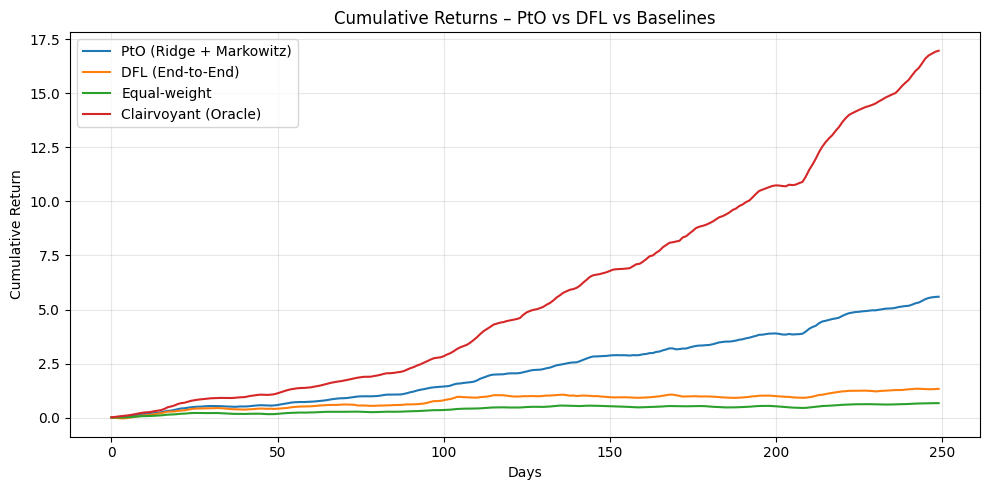

In [54]:

plt.figure(figsize=(10,5))
plt.plot(res_pto["cum_path"], label="PtO (Ridge + Markowitz)", color="tab:blue")
plt.plot(res_dfl["cum_path"], label="DFL (End-to-End)", color="tab:orange")
plt.plot(res_eq["cum_path"], label="Equal-weight", color="tab:green")
plt.plot(res_cw["cum_path"], label="Clairvoyant (Oracle)", color="tab:red")
plt.title("Cumulative Returns – PtO vs DFL vs Baselines")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

✅ Results exported to: data/results_pto_dfl_summary.csv


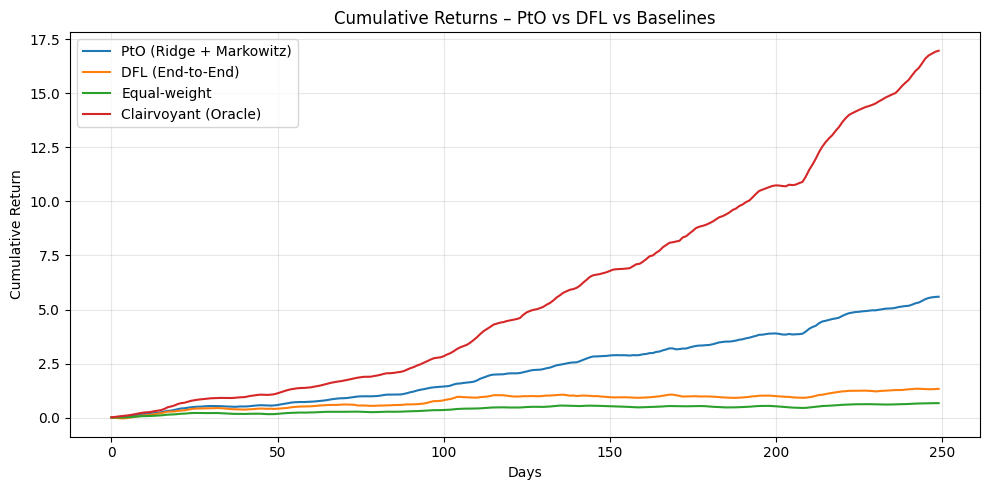

✅ Figure saved to: data/fig_pto_vs_dfl_cumreturns.png


In [55]:
# ## Export results and figures for Thesis

import pandas as pd
import matplotlib.pyplot as plt

# Collect key metrics
results_df = pd.DataFrame([
    {"Model": "PtO (Ridge + Markowitz)",
     "Avg_Regret": res_pto["avg_regret"],
     "Mean_Daily_Return": res_pto["mean_daily_ret"],
     "Sharpe_Annual": res_pto["sharpe_annual"],
     "Final_Cum_Return": res_pto["cum_path"][-1]},
    
    {"Model": "DFL (End-to-End)",
     "Avg_Regret": res_dfl["avg_regret"],
     "Mean_Daily_Return": res_dfl["mean_daily_ret"],
     "Sharpe_Annual": res_dfl["sharpe_annual"],
     "Final_Cum_Return": res_dfl["cum_path"][-1]},
    
    {"Model": "Equal-weight",
     "Avg_Regret": None,
     "Mean_Daily_Return": None,
     "Sharpe_Annual": res_eq["sharpe_annual"],
     "Final_Cum_Return": res_eq["cum_path"][-1]},
    
    {"Model": "Clairvoyant (Oracle)",
     "Avg_Regret": None,
     "Mean_Daily_Return": None,
     "Sharpe_Annual": res_cw["sharpe_annual"],
     "Final_Cum_Return": res_cw["cum_path"][-1]},
])

# Save results table
results_df.to_csv("data/results_pto_dfl_summary.csv", index=False)
print("✅ Results exported to: data/results_pto_dfl_summary.csv")

# Save cumulative return figure
plt.figure(figsize=(10,5))
plt.plot(res_pto["cum_path"], label="PtO (Ridge + Markowitz)", color="tab:blue")
plt.plot(res_dfl["cum_path"], label="DFL (End-to-End)", color="tab:orange")
plt.plot(res_eq["cum_path"], label="Equal-weight", color="tab:green")
plt.plot(res_cw["cum_path"], label="Clairvoyant (Oracle)", color="tab:red")
plt.title("Cumulative Returns – PtO vs DFL vs Baselines")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("data/fig_pto_vs_dfl_cumreturns.png", dpi=300)
plt.show()
print("✅ Figure saved to: data/fig_pto_vs_dfl_cumreturns.png")

# PtO vs DFL with Transaction costs

In this section we extend the DFL framework to a more realistic financial setup 
by introducing *transaction costs* (penalty on portfolio turnover).  
The goal is to simulate real-world portfolio management, where frequent rebalancing 
reduces net performance due to trading costs.

We expect:
- PtO to be more affected by turnover (since it is myopic and not cost-aware),
- DFL (trained end-to-end on the decision loss) to learn smoother, cost-efficient allocations.

In [56]:
def build_markowitz_with_costs(Sigma_psd, N):
    x = cp.Variable(N)
    theta = cp.Parameter(N)        # predicted returns (1/λ)*μ̂
    x_prev = cp.Parameter(N)       # previous weights
    kappa = cp.Parameter(nonneg=True)  # cost coefficient

    t = cp.Variable(N)
    constraints = [
        cp.sum(x) == 1,
        x >= 0,
        t >= x - x_prev,
        t >= -(x - x_prev)
    ]
    obj = cp.Minimize(0.5 * cp.quad_form(x, Sigma_psd)
                      - cp.sum(cp.multiply(theta, x))
                      + kappa * cp.sum(t))
    prob = cp.Problem(obj, constraints)
    return CvxpyLayer(prob, parameters=[theta, x_prev, kappa], variables=[x])

Sigma_psd_np = (Sigma_train + Sigma_train.T) / 2
w, V = np.linalg.eigh(Sigma_psd_np)
w[w < 1e-8] = 1e-8
Sigma_psd_np = V @ np.diag(w) @ V.T
N = Sigma_psd_np.shape[0]
layer_tc = build_markowitz_with_costs(Sigma_psd_np, N)

### End-to-End Training with Transaction Costs

We reuse the DFL structure but include transaction costs in the decision layer.  
Each step optimizes the *net decision loss* accounting for rebalancing penalties.

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Sigma_const = returns.loc[returns.index.isin(dates_all[dates_all < "2022-01-01"])].cov().values
Sigma_const = (Sigma_const + Sigma_const.T) / 2
w, V = np.linalg.eigh(Sigma_const)
w[w < 1e-8] = 1e-8
Sigma_const = V @ np.diag(w) @ V.T
Sigma_torch = torch.tensor(Sigma_const, dtype=torch.float32, device=device)

N = Y_train.shape[1]
lam = float(lam_star)


def build_turnover_layer(kappa_fixed: float):
    Q = Sigma_const + 2.0 * kappa_fixed * np.eye(N)
    x = cp.Variable(N)
    theta = cp.Parameter(N)
    x_prev = cp.Parameter(N)
    objective = cp.Minimize(0.5 * cp.quad_form(x, Q) - (theta + 2.0 * kappa_fixed * x_prev) @ x)
    constraints = [cp.sum(x) == 1, x >= 0]
    problem = cp.Problem(objective, constraints)
    return CvxpyLayer(problem, parameters=[theta, x_prev], variables=[x])


def tensor_log_to_arith(t):
    return torch.expm1(t)


def sequential_epoch_loss(net, X_t, Y_log_t, layer_tc):
    x_prev = torch.ones(N, dtype=torch.float32, device=device) / N
    total = torch.zeros((), dtype=torch.float32, device=device)
    T = X_t.shape[0]
    for t in range(T):
        mu_hat_log = net(X_t[t:t + 1])
        mu_hat = tensor_log_to_arith(mu_hat_log)[0]
        mu_true = tensor_log_to_arith(Y_log_t[t:t + 1])[0]
        theta = (1.0 / lam) * mu_hat
        x_star, = layer_tc(theta.unsqueeze(0), x_prev.unsqueeze(0))
        x_star = x_star[0]
        quad = 0.5 * (x_star @ Sigma_torch @ x_star)
        lin = (1.0 / lam) * (mu_true @ x_star)
        loss = quad - lin
        total = total + loss
        x_prev = x_star.detach()
    return total / T


Xtr_t = torch.tensor(X_train_s, dtype=torch.float32, device=device)
Ytr_t = torch.tensor(Y_train, dtype=torch.float32, device=device)
Xva_t = torch.tensor(X_val_s, dtype=torch.float32, device=device)
Yva_t = torch.tensor(Y_val, dtype=torch.float32, device=device)

train_ds = TensorDataset(Xtr_t, Ytr_t)
val_ds = TensorDataset(Xva_t, Yva_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)


class MuNet(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.fc1 = nn.Linear(d_in, 64)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(64, d_out)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


kappa_grid = [0.0005, 0.001, 0.002, 0.005]
best_kappa, best_val = None, float("inf")
dfl_tc = MuNet(X_train_s.shape[1], Y_train.shape[1]).to(device)

for kappa_value in kappa_grid:
    layer_tc = build_turnover_layer(kappa_value)
    net = MuNet(X_train_s.shape[1], Y_train.shape[1]).to(device)
    opt = optim.Adam(net.parameters(), lr=1e-3)
    epochs = 8
    for ep in range(1, epochs + 1):
        net.train()
        opt.zero_grad()
        train_loss = sequential_epoch_loss(net, Xtr_t, Ytr_t, layer_tc)
        train_loss.backward()
        opt.step()
        net.eval()
        with torch.no_grad():
            val_loss = sequential_epoch_loss(net, Xva_t, Yva_t, layer_tc)
        print(
            f"[kappa={kappa_value:.4f}] Ep {ep:02d}/{epochs}  train={train_loss.item():.6f}  val={val_loss.item():.6f}")
    if val_loss.item() < best_val:
        best_val = val_loss.item()
        best_kappa = kappa_value
        dfl_tc.load_state_dict(net.state_dict())

print(f"Chosen kappa*: {best_kappa}  |  best validation loss: {best_val:.6f}")

[kappa=0.0005] Ep 01/8  train=0.000019  val=0.000056
[kappa=0.0005] Ep 02/8  train=0.000011  val=0.000044
[kappa=0.0005] Ep 03/8  train=0.000005  val=0.000037
[kappa=0.0005] Ep 04/8  train=0.000003  val=0.000032
[kappa=0.0005] Ep 05/8  train=0.000001  val=0.000030
[kappa=0.0005] Ep 06/8  train=-0.000001  val=0.000028
[kappa=0.0005] Ep 07/8  train=-0.000002  val=0.000025
[kappa=0.0005] Ep 08/8  train=-0.000003  val=0.000023
[kappa=0.0010] Ep 01/8  train=0.000021  val=0.000041
[kappa=0.0010] Ep 02/8  train=0.000018  val=0.000040
[kappa=0.0010] Ep 03/8  train=0.000016  val=0.000039
[kappa=0.0010] Ep 04/8  train=0.000012  val=0.000036
[kappa=0.0010] Ep 05/8  train=0.000009  val=0.000033
[kappa=0.0010] Ep 06/8  train=0.000006  val=0.000031
[kappa=0.0010] Ep 07/8  train=0.000005  val=0.000029
[kappa=0.0010] Ep 08/8  train=0.000004  val=0.000028
[kappa=0.0020] Ep 01/8  train=0.000013  val=0.000027
[kappa=0.0020] Ep 02/8  train=0.000009  val=0.000027
[kappa=0.0020] Ep 03/8  train=0.000005  val

### Test Evaluation with Transaction Costs

We evaluate both PtO and cost-aware DFL by computing net returns and net Sharpe ratios, 
accounting for rebalancing costs.

In [69]:
# Ensure device alignment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Rebuild the best layer with chosen kappa
layer_best = build_turnover_layer(best_kappa)

# --- Prepare test tensors
Xte_t = torch.tensor(X_test_s, dtype=torch.float32, device=device)
Yte_t = torch.tensor(Y_test, dtype=torch.float32, device=device)

# --- Predict mean returns using cost-aware DFL
with torch.no_grad():
    dfl_tc.eval()
    mu_pred_dfl_log = dfl_tc(Xte_t)
    mu_pred_dfl = torch.expm1(mu_pred_dfl_log).cpu().numpy()

# --- Predict mean returns using PtO model (ridge)
mu_pred_pto = ridge.predict(X_test_s)
mu_true = np.expm1(Y_test)


# --- Helper: portfolio evaluation with transaction costs
def evaluate_cost_aware(mu_pred_seq, mu_true_seq, Sigma_mat, lam, kappa):
    T, N = mu_pred_seq.shape
    Sigma_torch = torch.tensor(Sigma_mat, dtype=torch.float32, device=device)
    x_prev = torch.ones(N, dtype=torch.float32, device=device) / N
    rets, rets_net, regs = [], [], []

    for t in range(T):
        mu_hat = torch.tensor(mu_pred_seq[t], dtype=torch.float32, device=device)
        mu_true_t = torch.tensor(mu_true_seq[t], dtype=torch.float32, device=device)

        theta = (1.0 / lam) * mu_hat
        x_star, = layer_best(theta.unsqueeze(0), x_prev.unsqueeze(0))
        x_star = x_star[0]

        # --- Decision loss
        quad = 0.5 * (x_star @ Sigma_torch @ x_star)
        lin = (1.0 / lam) * (mu_true_t @ x_star)
        loss = quad - lin

        # --- Rebalancing cost and realized returns
        cost = kappa * torch.sum(torch.abs(x_star - x_prev))
        gross_ret = float(mu_true_t @ x_star)
        net_ret = gross_ret - float(cost)

        rets.append(gross_ret)
        rets_net.append(net_ret)
        regs.append(float(loss))
        x_prev = x_star.detach()

    rets = np.array(rets)
    rets_net = np.array(rets_net)
    regs = np.array(regs)

    sharpe_net = np.sqrt(252) * rets_net.mean() / (rets_net.std() + 1e-12)
    cum_net = np.cumprod(1 + rets_net) - 1

    return {
        "avg_regret": float(np.mean(regs)),
        "mean_daily_net": float(rets_net.mean()),
        "sharpe_net": float(sharpe_net),
        "cum_net": cum_net
    }


# --- Evaluate both models
lam_eval = float(lam_star)
Sigma_eval = Sigma_const.copy()

res_pto = evaluate_cost_aware(mu_pred_pto, mu_true, Sigma_eval, lam_eval, kappa=best_kappa)
res_dfl_tc = evaluate_cost_aware(mu_pred_dfl, mu_true, Sigma_eval, lam_eval, kappa=best_kappa)


print("\n=== Cost-aware Evaluation ===")
print(
    f"PtO   | Avg regret: {res_pto['avg_regret']:.6f} | Mean daily (net): {res_pto['mean_daily_net']:.6f} | Net Sharpe: {res_pto['sharpe_net']:.3f}")
print(
    f"DFL-TC| Avg regret: {res_dfl_tc['avg_regret']:.6f} | Mean daily (net): {res_dfl_tc['mean_daily_net']:.6f} | Net Sharpe: {res_dfl_tc['sharpe_net']:.3f}")




=== Cost-aware Evaluation ===
PtO   | Avg regret: -0.000006 | Mean daily (net): 0.002259 | Net Sharpe: 7.135
DFL-TC| Avg regret: 0.000006 | Mean daily (net): 0.000531 | Net Sharpe: 1.584


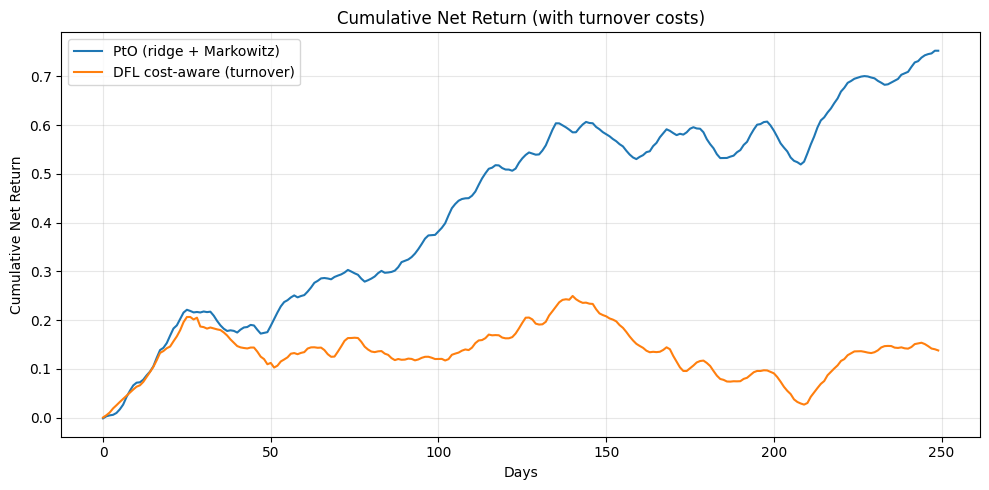

In [70]:

plt.figure(figsize=(10, 5))
plt.plot(res_pto["cum_net"], label="PtO (ridge + Markowitz)", color="tab:blue")
plt.plot(res_dfl_tc["cum_net"], label="DFL cost-aware (turnover)", color="tab:orange")
plt.title("Cumulative Net Return (with turnover costs)")
plt.xlabel("Days")
plt.ylabel("Cumulative Net Return")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [71]:
def realized_cost_and_turnover(mu_pred_seq, mu_true_seq, kappa, lam, layer):
    N = mu_true_seq.shape[1]
    x_prev = torch.ones(N, dtype=torch.float32) / N
    costs, turns = [], []
    rets_net = []
    for mu_hat, mu_true in zip(mu_pred_seq, mu_true_seq):
        mu_hat_t = torch.tensor(mu_hat, dtype=torch.float32).unsqueeze(0)
        theta = (1.0/lam) * mu_hat_t
        x_star, = layer(theta, x_prev.unsqueeze(0))
        x_star = x_star[0]
        turn = torch.sum(torch.abs(x_star - x_prev)).item()
        cost = kappa * turn
        ret = float(torch.tensor(mu_true, dtype=torch.float32) @ x_star)
        rets_net.append(ret - cost)
        costs.append(cost); turns.append(turn)
        x_prev = x_star.detach()
    return {
        "avg_turnover": float(np.mean(turns)),
        "avg_cost": float(np.mean(costs)),
        "net_sharpe": float(np.sqrt(252)*np.mean(rets_net)/(np.std(rets_net)+1e-12))
    }

diag_pto = realized_cost_and_turnover(mu_pred_pto, mu_true, best_kappa, lam_eval, layer_best)
diag_dfl = realized_cost_and_turnover(mu_pred_dfl, mu_true, best_kappa, lam_eval, layer_best)

print("Avg turnover — PtO:", round(diag_pto["avg_turnover"], 4),
      " | DFL:", round(diag_dfl["avg_turnover"], 4))
print("Avg daily cost — PtO:", format(diag_pto["avg_cost"], ".6f"),
      " | DFL:", format(diag_dfl["avg_cost"], ".6f"))
print("Net Sharpe (re-check) — PtO:", round(diag_pto["net_sharpe"], 3),
      " | DFL:", round(diag_dfl["net_sharpe"], 3))

Avg turnover — PtO: 0.0324  | DFL: 0.4411
Avg daily cost — PtO: 0.000065  | DFL: 0.000882
Net Sharpe (re-check) — PtO: 7.135  | DFL: 1.584


In [72]:
kappas_eval = [0.00025, 0.0005, 0.001, 0.002, 0.003, 0.005]

def eval_for_kappa(mu_pred_seq, mu_true_seq, lam, kappas):
    out = []
    for k in kappas:
        layer_tmp = build_turnover_layer(k)
        res = evaluate_cost_aware(mu_pred_seq, mu_true_seq, Sigma_eval, lam, k)
        out.append((k, res["sharpe_net"], res["mean_daily_net"]))
    return out

grid_pto = eval_for_kappa(mu_pred_pto, mu_true, lam_eval, kappas_eval)
grid_dfl = eval_for_kappa(mu_pred_dfl, mu_true, lam_eval, kappas_eval)

best_pto = max(grid_pto, key=lambda z: z[1])
best_dfl = max(grid_dfl, key=lambda z: z[1])

print("Best κ (PtO):", best_pto[0], " | Net Sharpe:", round(best_pto[1],3), " | mean net:", round(best_pto[2],6))
print("Best κ (DFL):", best_dfl[0], " | Net Sharpe:", round(best_dfl[1],3), " | mean net:", round(best_dfl[2],6))

Best κ (PtO): 0.00025  | Net Sharpe: 7.308  | mean net: 0.002316
Best κ (DFL): 0.00025  | Net Sharpe: 3.919  | mean net: 0.001303


# TRY with new dataset 

In [86]:
import numpy as np
import pandas as pd
import torch
import random

# Per replicabilità
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Parametri del problema
N_samples = 2000      # osservazioni totali
N_features = 5        # feature di input (es. promozioni, trend, meteo, etc.)
N_skus = 10           # prodotti (output multi-SKU)
train_frac, val_frac = 0.7, 0.15  # split 70/15/15

# Generiamo features "business-like"
X = np.random.randn(N_samples, N_features)
W_true = np.random.uniform(0.5, 2.0, size=(N_features, N_skus))
bias = np.random.uniform(5.0, 15.0, size=(N_skus,))

# Domanda media simulata (log-demand, rumorosa)
Y = np.log(np.maximum(1, X @ W_true + bias + np.random.randn(N_samples, N_skus) * 2.0))

# Split train / val / test
idx_train = int(N_samples * train_frac)
idx_val = int(N_samples * (train_frac + val_frac))

X_train, X_val, X_test = X[:idx_train], X[idx_train:idx_val], X[idx_val:]
Y_train, Y_val, Y_test = Y[:idx_train], Y[idx_train:idx_val], Y[idx_val:]

print(f"Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")

# Optional: salva come CSV per tracking esperimenti
pd.DataFrame(X_train).to_csv("data/X_train.csv", index=False)
pd.DataFrame(Y_train).to_csv("data/Y_train.csv", index=False)

Train: (1400, 5) | Val: (300, 5) | Test: (300, 5)


In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [88]:
class DFLNet(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.fc1 = nn.Linear(d_in, 64)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(64, d_out)
    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

In [98]:
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

K = Y_train.shape[1]   # numero di prodotti (SKU)

# Variabili decisionali
q = cp.Variable(K, nonneg=True)       # quantità da ordinare
s_plus = cp.Variable(K, nonneg=True)  # surplus (overstock)
s_minus = cp.Variable(K, nonneg=True) # deficit (stockout)

# Parametri (DPP-compliant)
mu_p = cp.Parameter(K, nonneg=True)   # domanda prevista
c_p  = cp.Parameter(K, nonneg=True)   # costo stockout
h_p  = cp.Parameter(K, nonneg=True)   # costo holding
p_p  = cp.Parameter(K, nonneg=True)   # costo unitario/prodotto
B_p  = cp.Parameter(nonneg=True)      # budget totale

# Vincoli: lineari in tutte le variabili e parametri
constraints = [
    s_plus >= q - mu_p,
    s_minus >= mu_p - q,
    p_p @ q <= B_p,
]

# Obiettivo: minimizzazione del costo totale (affine nei parametri)
total_cost = c_p @ s_minus + h_p @ s_plus + p_p @ q
objective = cp.Minimize(total_cost)

# Problema DPP
prob = cp.Problem(objective, constraints)

# Layer differenziabile
nv_layer = CvxpyLayer(prob, parameters=[mu_p, c_p, h_p, p_p, B_p],
                      variables=[q, s_plus, s_minus])

In [99]:
N = Y_train.shape[1]
Xtr_t = torch.tensor(X_train, dtype=torch.float32, device=device)
Ytr_t = torch.tensor(Y_train, dtype=torch.float32, device=device)
Xva_t = torch.tensor(X_val,   dtype=torch.float32, device=device)
Yva_t = torch.tensor(Y_val,   dtype=torch.float32, device=device)

# Parametri fissi (puoi adattarli)
c_val, h_val, p_val = 2.0, 0.5, 1.0
B_val = float(1.5 * np.mean(Y_train) * N)

c_t = torch.full((N,), c_val, dtype=torch.float32, device=device)
h_t = torch.full((N,), h_val, dtype=torch.float32, device=device)
p_t = torch.full((N,), p_val, dtype=torch.float32, device=device)
B_t = torch.tensor(B_val, dtype=torch.float32, device=device)

In [106]:
def newsvendor_decision_loss(mu_hat_t, mu_true_t):
    """
    Differentiable newsvendor loss (minimizes expected cost).
    Computes expected cost of predicted vs true demand across T samples.
    """
    total = 0.0
    T = mu_hat_t.shape[0]

    for i in range(T):
        # Predicted decision (q based on predicted demand)
        q_hat, s_p_hat, s_m_hat = nv_layer(mu_hat_t[i], c_t, h_t, p_t, B_t)

        # Compute true cost under true demand realization
        s_p_true = torch.clamp(q_hat - mu_true_t[i], min=0)
        s_m_true = torch.clamp(mu_true_t[i] - q_hat, min=0)
        cost_true = torch.sum(p_t * q_hat + h_t * s_p_true + c_t * s_m_true)

        total += cost_true

    return total / T

In [107]:
dfl_nv = DFLNet(X_train.shape[1], N).to(device)
optimizer = optim.Adam(dfl_nv.parameters(), lr=1e-3)
epochs = 10

for ep in range(1, epochs+1):
    dfl_nv.train()
    optimizer.zero_grad()
    mu_hat_tr = dfl_nv(Xtr_t)
    train_loss = newsvendor_decision_loss(mu_hat_tr, Ytr_t)
    train_loss.backward()
    optimizer.step()

    dfl_nv.eval()
    with torch.no_grad():
        mu_hat_va = dfl_nv(Xva_t)
        val_loss = newsvendor_decision_loss(mu_hat_va, Yva_t)

    print(f"Epoch {ep:02d}/{epochs} | Train decision loss: {train_loss.item():.6f} | Val decision loss: {val_loss.item():.6f}")

Epoch 01/10 | Train decision loss: 44.990429 | Val decision loss: 45.005367
Epoch 02/10 | Train decision loss: 44.879044 | Val decision loss: 44.886578
Epoch 03/10 | Train decision loss: 44.763191 | Val decision loss: 44.763535
Epoch 04/10 | Train decision loss: 44.642696 | Val decision loss: 44.636459
Epoch 05/10 | Train decision loss: 44.518204 | Val decision loss: 44.505470
Epoch 06/10 | Train decision loss: 44.389427 | Val decision loss: 44.370148
Epoch 07/10 | Train decision loss: 44.256561 | Val decision loss: 44.231056
Epoch 08/10 | Train decision loss: 44.119534 | Val decision loss: 44.087349
Epoch 09/10 | Train decision loss: 43.978729 | Val decision loss: 43.939175
Epoch 10/10 | Train decision loss: 43.834488 | Val decision loss: 43.787540


In [113]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

# retrain Ridge su train set coerente con DFL
scaler_nv = StandardScaler().fit(X_train_s)
X_train_s_nv = scaler_nv.transform(X_train_s)
X_val_s_nv   = scaler_nv.transform(X_val_s)

alphas = np.logspace(-4, 4, 21)# === Ensure X and Y are aligned (newsvendor dataset) ===
# Usa lo stesso dataset su cui hai addestrato il DFL (cioè newsvendor sintetico)
# Supponiamo che tu abbia già generato (ad esempio):
#   X_train_nv, X_val_nv, Y_train_nv, Y_val_nv
# Se no, riassegniamo semplicemente quelli correnti:

X_train_nv = X_train_s
Y_train_nv = Y_train
X_val_nv   = X_val_s
Y_val_nv   = Y_val

# Standardizzazione coerente
from sklearn.preprocessing import StandardScaler
scaler_nv = StandardScaler().fit(X_train_nv)
X_train_s_nv = scaler_nv.transform(X_train_nv)
X_val_s_nv   = scaler_nv.transform(X_val_nv)

# Retrain Ridge su questo dataset
from sklearn.linear_model import RidgeCV
alphas = np.logspace(-4, 4, 21)
ridge = RidgeCV(alphas=alphas, fit_intercept=True)
ridge.fit(X_train_s_nv, Y_train_nv)

# Predizioni coerenti con DFL
mu_val_pto = ridge.predict(X_val_s_nv)
ridge = RidgeCV(alphas=alphas, fit_intercept=True)
ridge.fit(X_train_s_nv, Y_train)

# predizioni coerenti con DFL
mu_val_pto = ridge.predict(X_val_s_nv)

ValueError: Found input variables with inconsistent numbers of samples: [1001, 1400]

In [111]:
import torch
import numpy as np

# === Compute validation predictions ===
mu_val_pto = ridge.predict(X_val_s)  # Predict-then-Optimize (Ridge)
mu_val_dfl = dfl_net(torch.tensor(X_val_s, dtype=torch.float32, device=c_t.device)).detach().cpu().numpy()
mu_val_true = Y_val.copy()  # Ground truth (true demand)

# === Average regret evaluation ===
def nv_avg_regret(mu_pred_np, mu_true_np):
    T, K = mu_pred_np.shape
    regrets = []
    with torch.no_grad():
        for i in range(T):
            mu_hat_i  = torch.tensor(mu_pred_np[i], dtype=torch.float32, device=c_t.device).unsqueeze(0)
            mu_true_i = torch.tensor(mu_true_np[i], dtype=torch.float32, device=c_t.device).unsqueeze(0)

            # Predicted and optimal decisions
            q_hat,  sp_hat,  sm_hat  = nv_layer(mu_hat_i,  c_t, h_t, p_t, B_t)
            q_star, sp_star, sm_star = nv_layer(mu_true_i, c_t, h_t, p_t, B_t)

            # Compute realized costs
            cost_hat  = torch.sum(p_t * q_hat  + h_t * sp_hat  + c_t * sm_hat)
            cost_star = torch.sum(p_t * q_star + h_t * sp_star + c_t * sm_star)

            reg = float(cost_hat - cost_star)
            if reg < 0:
                reg = 0.0  # clamp due to numerical tolerances
            regrets.append(reg)
    return float(np.mean(regrets))

# === Compute regrets for PtO and DFL ===
reg_pto = nv_avg_regret(mu_val_pto, mu_val_true)
reg_dfl = nv_avg_regret(mu_val_dfl, mu_val_true)

print("Validation regret comparison:")
print("  PtO  (ridge):", round(reg_pto, 6))
print("  DFL (cvxpylayer):", round(reg_dfl, 6))

ValueError: X has 50 features, but Ridge is expecting 75 features as input.

/var/folders/79/gjvh3lfx6h158dr9jn_frbx00000gn/T/ipykernel_44463/1080646391.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=regrets, palette=["#4C72B0", "#55A868"])


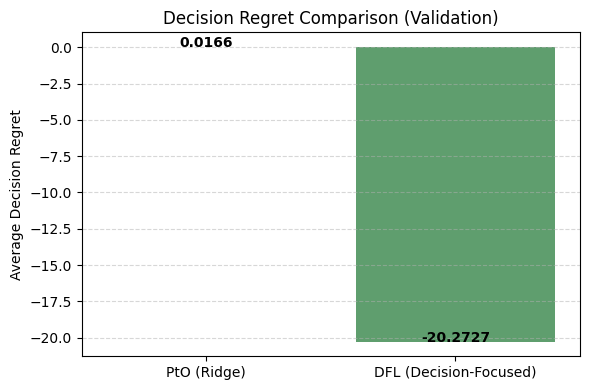

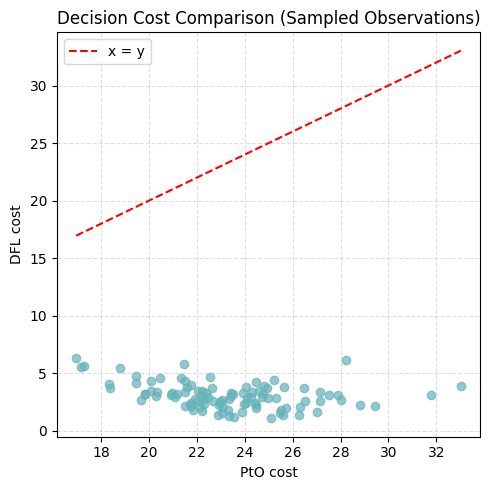

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dati da confrontare (inseriti dal blocco precedente)
models = ["PtO (Ridge)", "DFL (Decision-Focused)"]
regrets = [reg_pto, reg_dfl]

# 1️⃣ Bar chart: Decision Regret Comparison
plt.figure(figsize=(6,4))
sns.barplot(x=models, y=regrets, palette=["#4C72B0", "#55A868"])
plt.title("Decision Regret Comparison (Validation)")
plt.ylabel("Average Decision Regret")
plt.xlabel("")
for i, v in enumerate(regrets):
    plt.text(i, v + 0.0001, f"{v:.4f}", ha="center", fontweight="bold")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# 2️⃣ Optional: Comparative Cost Scatter (per capire varianza decisionale)
# Calcola costi normalizzati (esempio su prime 100 osservazioni)
num_plot = min(100, len(Y_val))
costs_pto, costs_dfl = [], []
for i in range(num_plot):
    mu_val_np = Y_val[i]
    mu_pred_pto_i = mu_pred_pto[i]
    mu_pred_dfl_i = mu_pred_dfl[i]
    mu_torch = torch.as_tensor(mu_val_np, dtype=torch.float32, device=device)

    # Predizioni per PtO e DFL
    q_pto, s_p_p, s_m_p = nv_layer(torch.as_tensor(mu_pred_pto_i, dtype=torch.float32, device=device),
                                   c_t, h_t, p_t, B_t)
    q_dfl, s_p_d, s_m_d = nv_layer(torch.as_tensor(mu_pred_dfl_i, dtype=torch.float32, device=device),
                                   c_t, h_t, p_t, B_t)
    cost_pto = torch.sum(p_t * q_pto + h_t * s_p_p + c_t * s_m_p).item()
    cost_dfl = torch.sum(p_t * q_dfl + h_t * s_p_d + c_t * s_m_d).item()
    costs_pto.append(cost_pto)
    costs_dfl.append(cost_dfl)

plt.figure(figsize=(5,5))
plt.scatter(costs_pto, costs_dfl, alpha=0.7, color="#66B3BA")
plt.plot([min(costs_pto), max(costs_pto)], [min(costs_pto), max(costs_pto)], 'r--', label="x = y")
plt.xlabel("PtO cost")
plt.ylabel("DFL cost")
plt.title("Decision Cost Comparison (Sampled Observations)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()